In [1]:
#Spotify module
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

#Sklearn module
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

#Sentiment analysis module
from textblob import TextBlob

#Useful libraries
import pandas as pd
from tqdm import tqdm
import re
from skimage import io
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


## Content-Based Reccomandation system per brani musicali

Il nostro punto di partenza è il dataset [Spotify Million Playlist Dataset](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge). Data la vastità di tale dataset si procederà a considerare un suo sottoinsieme composto da 1000 playlist.

In [2]:
dataPath = 'data/raw_data.csv'
df = pd.read_csv(dataPath)
df.drop(columns={"Unnamed: 0"},inplace=True)
df

,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,name
0,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,Throwbacks
1,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,Throwbacks
2,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),Throwbacks
3,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,Throwbacks
4,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,Throwbacks
...,...,...,...,...,...,...,...,...,...
67498,39,James Arthur,spotify:track:5uCax9HTNlzGybIStD3vDh,spotify:artist:4IWBUUAFIplrNtaOHcJPRM,Say You Won't Let Go,spotify:album:7oiJYvEJHsmYtrgviAVIBD,211466,Back from the Edge,thinking of you
67499,40,Big Words,spotify:track:0P1oO2gREMYUCoOkzYAyFu,spotify:artist:0sHN89qak07mnug3LVVjzP,The Answer,spotify:album:5jrsRHRAmetu5e7RRBoxj7,263679,"Hollywood, a Beautiful Coincidence",thinking of you
67500,41,Allan Rayman,spotify:track:2oM4BuruDnEvk59IvIXCwn,spotify:artist:6Yv6OBXD6ZQakEljaGaDAk,25.22,spotify:album:3CbNgBzI7r9o0F6VjH9sTY,189213,Roadhouse 01,thinking of you
67501,42,Jon Jason,spotify:track:4Ri5TTUgjM96tbQZd5Ua7V,spotify:artist:77bNdkKYBBmc30CisCA6tE,Good Feeling,spotify:album:2dZ7oVNQBeLlpoUYfbEsJP,194720,Good Feeling,thinking of you


All'interno del dataset troviamo 67503 brani che provengono da 1000 playlist, di conseguenza è possibile che diversi brani siano presenti più volte al suo interno.
Si procederà successivamente ad aggiungere a tale dataset una playlist personale proveniente da Spotify.

In [3]:
#Sistemo il formato dell'uri dei brani
df["track_uri"] = df["track_uri"].apply(lambda x: re.findall(r'\w+$', x)[0])
df["track_uri"]

0        0UaMYEvWZi0ZqiDOoHU3YI
1        6I9VzXrHxO9rA9A5euc8Ak
2        0WqIKmW4BTrj3eJFmnCKMv
3        1AWQoqb9bSvzTjaLralEkT
4        1lzr43nnXAijIGYnCT8M8H
                  ...          
67498    5uCax9HTNlzGybIStD3vDh
67499    0P1oO2gREMYUCoOkzYAyFu
67500    2oM4BuruDnEvk59IvIXCwn
67501    4Ri5TTUgjM96tbQZd5Ua7V
67502    5RVuBrXVLptAEbGJdSDzL5
Name: track_uri, Length: 67503, dtype: object

## Estrazione features

In [4]:
def uri_to_features(uri):

    with open("secret.txt") as f:
        secret_ls = f.readlines()
        cid = secret_ls[0].replace("\n","")
        secret = secret_ls[1]

    client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
    sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)
    
    #Audio features
    features = sp.audio_features(uri)[0]
    
    #Artista, genere e popolarità
    artist = sp.track(uri)["artists"][0]["id"]
    artist_pop = sp.artist(artist)["popularity"]
    artist_genres = sp.artist(artist)["genres"]
    
    #Popolarità del brano
    track_pop = sp.track(uri)["popularity"]
    
    #Add in extra features
    features["artist_pop"] = artist_pop
    if artist_genres:
        features["genres"] = " ".join([re.sub(' ','_',i) for i in artist_genres])
    else:
        features["genres"] = "unknown"
    features["track_pop"] = track_pop
    
    return features


Osserviamo un esempio di features estratte dalla nostra funzione:

In [5]:
uri_to_features(df['track_uri'][1])

{'danceability': 0.774,
 'energy': 0.838,
 'key': 5,
 'loudness': -3.914,
 'mode': 0,
 'speechiness': 0.114,
 'acousticness': 0.0249,
 'instrumentalness': 0.025,
 'liveness': 0.242,
 'valence': 0.924,
 'tempo': 143.04,
 'type': 'audio_features',
 'id': '6I9VzXrHxO9rA9A5euc8Ak',
 'uri': 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak',
 'track_href': 'https://api.spotify.com/v1/tracks/6I9VzXrHxO9rA9A5euc8Ak',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/6I9VzXrHxO9rA9A5euc8Ak',
 'duration_ms': 198800,
 'time_signature': 4,
 'artist_pop': 78,
 'genres': 'dance_pop pop post-teen_pop',
 'track_pop': 82}

Procediamo ad estrarre le features dai brani. Il dataset verrà suddiviso in 3 parti in quanto la computazione richiede molto tempo.

In [ ]:
first_half = df["track_uri"].unique()[:10000]
second_half = df["track_uri"].unique()[10000:20000]
third_half = df["track_uri"].unique()[20000:]
dataLIST = [first_half,second_half,third_half]

In [ ]:
featureLIST = []

for i in tqdm([uri for uri in dataLIST[0]]):
    try:
        featureLIST.append(uri_to_features(i))
    except:
        continue

In [ ]:
for i in tqdm([uri for uri in dataLIST[1]]):
    try:
        featureLIST.append(uri_to_features(i))
    except:
        continue

In [ ]:
for i in tqdm([uri for uri in dataLIST[2]]):
    try:
        featureLIST.append(uri_to_features(i))
    except:
        continue

In [ ]:
featureDF = pd.DataFrame(featureLIST)
new_df = pd.merge(testDF,featureDF, left_on = "track_uri", right_on= "id")
new_df.to_csv('/data/processed_data.csv')

In [6]:
#Carichiamo il dataset processato

playlist_df = pd.read_csv("data/processed_data.csv")
print(playlist_df.columns)
playlist_df.drop(columns=["Unnamed: 0",'Unnamed: 0.1'], inplace = True)
playlist_df.head()

Index(['Unnamed: 0', 'Unnamed: 0.1', 'pos', 'artist_name', 'track_uri',
       'artist_uri', 'track_name', 'album_uri', 'duration_ms_x', 'album_name',
       'name', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'duration_ms_y', 'time_signature', 'artist_pop', 'genres', 'track_pop'],
      dtype='object')


,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms_x,album_name,name,danceability,...,type,id,uri,track_href,analysis_url,duration_ms_y,time_signature,artist_pop,genres,track_pop
0,0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,Throwbacks,0.904,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69
1,73,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,w o r k o u t,0.904,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69
2,14,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,party playlist,0.904,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69
3,42,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,Dance mix,0.904,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69
4,1,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,spin,0.904,...,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69


Procediamo adesso ad integrare a tale dataset una playlist personale. 

In [7]:
def playlist_to_df(id,playlist_name):
    
    df_dict={}
    with open("secret.txt") as f:
        secret_ls = f.readlines()
        cid = secret_ls[0].replace("\n","")
        secret = secret_ls[1]

    client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
    sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

    plist = sp.playlist_items(id)
    
    for col in df.columns:
        df_col=[]
        if col=='pos':
            for i in range(len(plist['items'])):
                df_col.append(i)
            df_dict[col]=df_col
        elif col=='artist_name':        
            for i in range(len(plist['items'])):
                df_col.append(plist['items'][i]['track']['album']['artists'][0]['name'])
            df_dict[col]=df_col
        elif col=='track_uri':    
            for i in range(len(plist['items'])):
                df_col.append(plist['items'][i]['track']['uri'])
            df_dict[col]=df_col
        elif col=='artist_uri':
            for i in range(len(plist['items'])):
                df_col.append(plist['items'][i]['track']['album']['artists'][0]['uri'])
            df_dict[col]=df_col
        elif col=='track_name':
            for i in range(len(plist['items'])):
                df_col.append(plist['items'][i]['track']['name'])
            df_dict[col]=df_col
        elif col=='album_uri':
            for i in range(len(plist['items'])):
                df_col.append(plist['items'][i]['track']['uri'])
            df_dict[col]=df_col
        elif col=='album_name': 
            for i in range(len(plist['items'])):
                df_col.append(plist['items'][i]['track']['album']['name'])
            df_dict[col]=df_col
        elif col=='name':
            for i in range(len(plist['items'])):
                df_col.append(playlist_name)
            df_dict[col]=df_col
        else:
            for i in range(len(plist['items'])):
                df_col.append(plist['items'][i]['track'][col])
            df_dict[col]=df_col
        
    df_out=pd.DataFrame.from_dict(df_dict)
    
    return df_out

In [8]:
df_myplaylist=playlist_to_df("2fDa2VqqY8BdlvesToOKWW","sunday_")
df_myplaylist

,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,name
0,0,Venerus,spotify:track:4OwlE95RK5QigIUNM8SF4Z,spotify:artist:49faW2w8eguUIAG5c85KcD,Ck,spotify:track:4OwlE95RK5QigIUNM8SF4Z,263501,Magica Musica,sunday_
1,1,Frankie Stew and Harvey Gunn,spotify:track:2xmYrrwXfSHyxq2ySr56Ik,spotify:artist:1jVvXqdwDHekLwFBamrcUx,Breathing Exercises,spotify:track:2xmYrrwXfSHyxq2ySr56Ik,151459,Breathing Exercises,sunday_
2,2,Feux,spotify:track:5jYVLPQxwgSe9SqwHKsKPV,spotify:artist:4bnTHHCHsFujaD34vWr4tV,Green Tea,spotify:track:5jYVLPQxwgSe9SqwHKsKPV,325374,PURE NINE,sunday_
3,3,Venerus,spotify:track:3bUnqPAsWfSWfrjADemgv2,spotify:artist:49faW2w8eguUIAG5c85KcD,Fulmini/Il fu Venerus,spotify:track:3bUnqPAsWfSWfrjADemgv2,280975,Love Anthem,sunday_
4,4,Cosmo,spotify:track:2pphEeii58iwarDGiRtrY6,spotify:artist:09LxneoTmRpuN3Jp8Ut4EX,Regata 70,spotify:track:2pphEeii58iwarDGiRtrY6,299200,L'ultima festa,sunday_
5,5,Post Nebbia,spotify:track:2sRuOQ3fg1EGzzcuBgohJX,spotify:artist:0BdiTIT0f1quCjphcLrwKZ,Televendite di quadri,spotify:track:2sRuOQ3fg1EGzzcuBgohJX,265500,Canale Paesaggi,sunday_
6,6,Frank Ocean,spotify:track:3xKsf9qdS1CyvXSMEid6g8,spotify:artist:2h93pZq0e7k5yf4dywlkpM,Pink + White,spotify:track:3xKsf9qdS1CyvXSMEid6g8,184516,Blonde,sunday_
7,7,Frank Ocean,spotify:track:7DfFc7a6Rwfi3YQMRbDMau,spotify:artist:2h93pZq0e7k5yf4dywlkpM,Thinkin Bout You,spotify:track:7DfFc7a6Rwfi3YQMRbDMau,200746,channel ORANGE,sunday_
8,8,Kofi Stone,spotify:track:7pvu6pOXOik6CEK1ymhcTN,spotify:artist:0htlZDCG9I8LSENteF1TyQ,Rodney Place,spotify:track:7pvu6pOXOik6CEK1ymhcTN,170630,Nobody Cares Till Everybody Does,sunday_
9,9,Che Lingo,spotify:track:2CZK0do1yJntY27iBK3PKD,spotify:artist:0xNKgWtSixAqcwJLM2c8ez,Dark Days,spotify:track:2CZK0do1yJntY27iBK3PKD,182640,The Worst Generation,sunday_


Procediamo a visualizzare la playlist.

In [33]:
def visualize_songs(playlist_id="",list_id=[]):
    
    if playlist_id != "":
    
        list_url_img=[]
        list_name=[]

        with open("secret.txt") as f:
            secret_ls = f.readlines()
            cid = secret_ls[0].replace("\n","")
            secret = secret_ls[1]

        client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
        sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

        plist = sp.playlist_items(playlist_id)

        for i in range(len(plist['items'])):
            list_url_img.append(plist['items'][i]['track']['album']['images'][1]['url'])
            list_name.append(plist['items'][i]['track']['album']['artists'][0]['name']+"-"+plist['items'][i]['track']['name'])

        dict_name_url={"url":list_url_img,"name":list_name}
        df=pd.DataFrame.from_dict(dict_name_url)


        temp = df['url'].values
        plt.figure(figsize=(15,int(0.625 * len(temp))))
        columns = 5

        for i, url in enumerate(temp):
            plt.subplot(len(temp)//columns+1, columns, i + 1)

            image = io.imread(url)
            plt.imshow(image)
            plt.xticks(color = 'w', fontsize = 0.1)
            plt.yticks(color = 'w', fontsize = 0.1)
            plt.xlabel(df['name'].values[i], fontsize = 12,color="white")
            plt.tight_layout(h_pad=0.4, w_pad=0)
            plt.subplots_adjust(wspace=None, hspace=None)

        plt.show()
        
    elif len(list_id)>=1:
        
        list_url_img=[]
        list_name=[]

        with open("secret.txt") as f:
            secret_ls = f.readlines()
            cid = secret_ls[0].replace("\n","")
            secret = secret_ls[1]

        client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
        sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)
        
        for song_id in list_id:
            
            plist = sp.track(song_id)
            list_url_img.append(plist['album']['images'][1]['url'])
            list_name.append(plist['album']['artists'][0]['name']+"-"+plist['name'])

        dict_name_url={"url":list_url_img,"name":list_name}
        df=pd.DataFrame.from_dict(dict_name_url)


        temp = df['url'].values
        plt.figure(figsize=(15,int(0.625 * len(temp))))
        columns = 5

        for i, url in enumerate(temp):
            plt.subplot(len(temp)//columns+1, columns, i + 1)

            image = io.imread(url)
            plt.imshow(image)
            plt.xticks(color = 'w', fontsize = 0.1)
            plt.yticks(color = 'w', fontsize = 0.1)
            plt.xlabel(df['name'].values[i], fontsize = 12,color="white")
            plt.tight_layout(h_pad=0.4, w_pad=0)
            plt.subplots_adjust(wspace=None, hspace=None)

        plt.show()
        

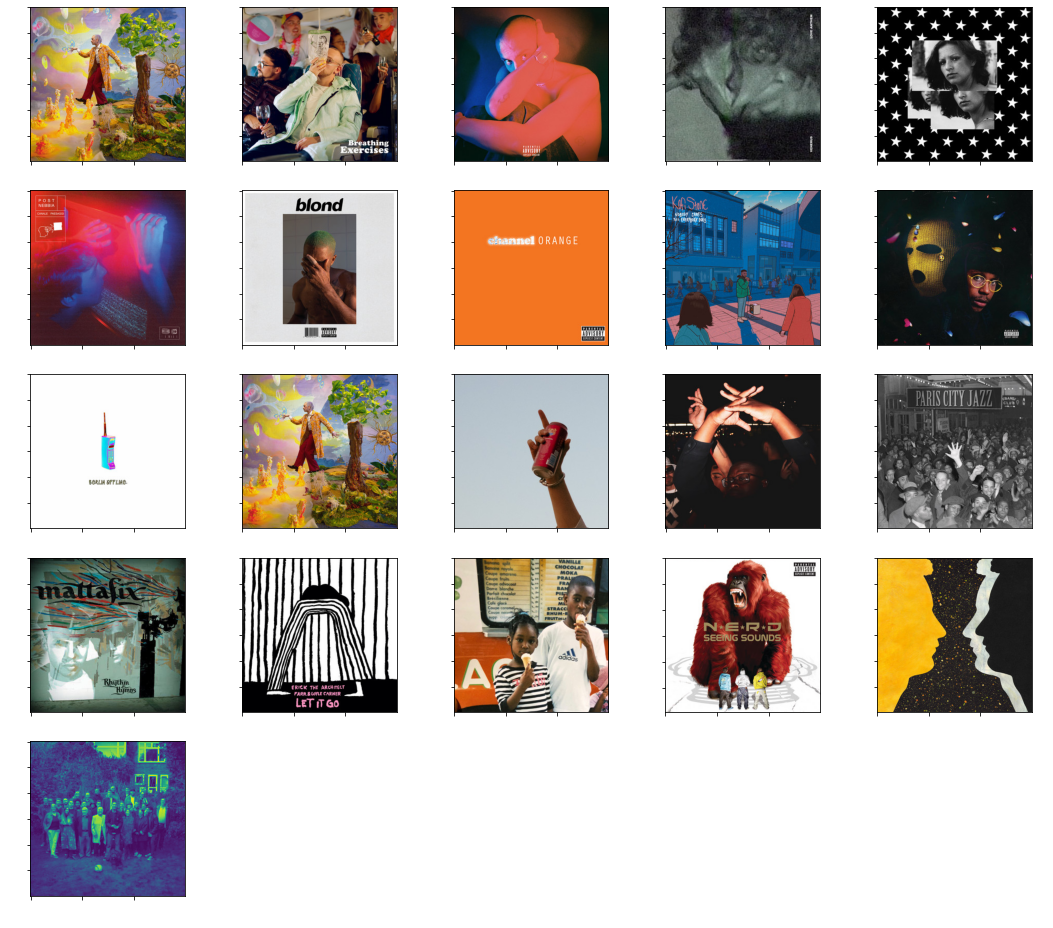

In [10]:
visualize_songs("2fDa2VqqY8BdlvesToOKWW")

Estraiamo le feature della nostra playlist e l'aggiungiamo al dataset.

In [11]:
df_myplaylist["track_uri"] = df_myplaylist["track_uri"].apply(lambda x: re.findall(r'\w+$', x)[0])
feature_myplaylist = []

for i in tqdm([uri for uri in df_myplaylist["track_uri"]]):
    try:
        feature_myplaylist.append(uri_to_features(i))
    except:
        continue
        
feature_df_myplaylist = pd.DataFrame(feature_myplaylist)
df_myplaylist_processed = pd.merge(df_myplaylist,feature_df_myplaylist, left_on = "track_uri", right_on= "id")

100%|██████████| 21/21 [00:41<00:00,  1.99s/it]


In [12]:
playlist_df=pd.concat([playlist_df,df_myplaylist_processed])

## Preprocessing

Osserviamo che nel dataset sono presenti dei duplicati.

In [13]:
playlist_df[['artist_name','track_name','name']].head()

,artist_name,track_name,name
0,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),Throwbacks
1,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),w o r k o u t
2,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),party playlist
3,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),Dance mix
4,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),spin


In [14]:
def drop_duplicates(df):
    
    df['artists_song'] = df.apply(lambda row: row['artist_name']+row['track_name'],axis = 1)
    
    return df.drop_duplicates('artists_song')

song_df = drop_duplicates(playlist_df)
print("Le canzoni sono uniche: ",len(pd.unique(song_df.artists_song))==len(song_df))

Le canzoni sono uniche:  True


Procediamo ora a selezionare le features che utilizzeremo in seguito. Di seguito abbiamo una loro lista suddivisa in categorie:
1. Metadata
    - id
    - genres
    - artist_pop
    - track_pop
2. Audio
    - **Mood**: Danceability, Valence, Energy, Tempo
    - **Properties**: Loudness, Speechiness, Instrumentalness
    - **Context**: Liveness, Acousticness
    - **metadata**: key, mode
3. Text
    - track_name

In [15]:
def select_cols(df):
    
       return df[['artist_name','id','track_name','danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', "artist_pop", "genres", "track_pop"]]
    
song_df = select_cols(song_df)
song_df.head()

,artist_name,id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_pop,genres,track_pop
0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69
6,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,Toxic,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,84,dance_pop pop post-teen_pop,83
19,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,86,dance_pop pop r&b,25
46,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,Rock Your Body,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,82,dance_pop pop,79
55,Shaggy,1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,75,pop_rap reggae_fusion,2


Trasformiamo ora i valori presenti nella colonna "genres" da stringa a lista.

In [16]:
def genre_preprocess(df):
  
    df['genres_list'] = df['genres'].apply(lambda x: x.split(" "))
    return df

song_df = genre_preprocess(song_df)
song_df['genres_list'].head()

0     [dance_pop, hip_hop, hip_pop, pop, pop_rap, r&...
6                       [dance_pop, pop, post-teen_pop]
19                                [dance_pop, pop, r&b]
46                                     [dance_pop, pop]
55                             [pop_rap, reggae_fusion]
Name: genres_list, dtype: object

In [17]:
def playlist_preprocess(df):
 
    df = drop_duplicates(df)
    df = select_cols(df)
    df = genre_preprocess(df)

    return df

### Feature Generation
Ora che i nostri dati si presentano in un formato utilizzabile possiamo fare feature-engineering per lo scopo di sviluppare un sistema di raccomandazione. Tale processo è condotto in una pipeline per la generatione delle feature, che è la seguente:

1. Sentiment Analysis
2. One-hot Encoding
3. TF-IDF
4. Normalizzazione

#### Sentiment Analysis

Nei nostri dati effettueremo una semplice sentiment analysis utilizzando la subjectivity e la polarità dalla libreria TextBlob.
- **Subjectivity** (0,1): Misura la quantità di opinione personale ed informazioni fattuali contenute nel testo.
- **Polarity** (-1,1): Il grado di forte o chiaramente definito sentiment, tenendo conto della negatività

Procederemo dopo ad utilizzare one-hot encoding per elencare il sentiment dei titoli delle canzoni.

In [18]:
def getSubjectivity(text):
  
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  
    return TextBlob(text).sentiment.polarity

def getAnalysis(score, task="polarity"):
 
    if task == "subjectivity":
        if score < 1/3:
            return "low"
        elif score > 1/3:
            return "high"
        else:
            return "medium"
    else:
        if score < 0:
            return 'Negative'
        elif score == 0:
            return 'Neutral'
        else:
            return 'Positive'

def sentiment_analysis(df, text_col):
    
    df['subjectivity'] = df[text_col].apply(getSubjectivity).apply(lambda x: getAnalysis(x,"subjectivity"))
    df['polarity'] = df[text_col].apply(getPolarity).apply(getAnalysis)
    return df

In [19]:
# Show result
sentiment = sentiment_analysis(song_df, "track_name")
sentiment.head()

,artist_name,id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_pop,genres,track_pop,genres_list,subjectivity,polarity
0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69,"[dance_pop, hip_hop, hip_pop, pop, pop_rap, r&...",low,Neutral
6,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,Toxic,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,84,dance_pop pop post-teen_pop,83,"[dance_pop, pop, post-teen_pop]",low,Neutral
19,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,86,dance_pop pop r&b,25,"[dance_pop, pop, r&b]",high,Negative
46,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,Rock Your Body,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,82,dance_pop pop,79,"[dance_pop, pop]",low,Neutral
55,Shaggy,1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,75,pop_rap reggae_fusion,2,"[pop_rap, reggae_fusion]",low,Neutral


#### One-hot encoding

One-hot encoding è il metodo per trasformare variabili categoriche in un linguaggio che sia capibile da una macchina. Questo è effettuato convertendo ciascuna categoria in una colonna così che ciascuna categoria possa essere rappresentata da un valore True o False.

In [20]:
def ohe_preparation(df, column, new_name): 
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

In [21]:
# One-hot encoding per la subjectivity 
subject_ohe = ohe_preparation(sentiment, 'subjectivity','subject')
subject_ohe.iloc[0]

subject|high      0
subject|low       1
subject|medium    0
Name: 0, dtype: uint8

## TF-IDF

TF-IDF, conosciuta anche come Term Frequency - Inverse Document Frequensy, è un tool per quantificare parole in un insieme di documenti. Il goal di questo tool è di mostrare l'imortanza di una parola all'interno del documento. 
La formula generale per calcolare TF-IDF è la seguente:

$$ \text{Term Frequency}\times\text{Inverse Document Frequency}$$
ove indichiamo :
- Term Frequency (TF) - il numero di volte che un termine appare in ciascun documento diviso dal numero totale di parole presenti nel documento.
- Inverse Document Frequency (IDF) - il logaritmo della frequenza del documento. La frequenza di un documento è il numero totale di documenti dove un termine è presente.

TF si focalizza sull'importanza di una parola in un documento, mentre IDF si focalizza sull'importante di una parola tra i vari documenti.
In questo progetto, i nostri documenti sono le canzoni. Per cui, stiamo calcolando i generi più diffusi in ciascuna canzone e la loro prevalenza tra le canzoni per determinare il peso del genere. Questo approccio è migliore rispetto al semplice utilizzo dell'one-hot encoding in quanto non ci sono pesi per determinare quanto è importante e diffuso ciascun genere è, il che può portare a dare un peso sovrastimato a generi non comuni.

In [22]:
# TF-IDF implementation
tfidf = TfidfVectorizer()
tfidf_matrix =  tfidf.fit_transform(song_df['genres_list'].apply(lambda x: " ".join(x)))
genre_df = pd.DataFrame(tfidf_matrix.toarray())
genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
genre_df.drop(columns='genre|unknown')
genre_df.reset_index(drop = True, inplace=True)
genre_df.iloc[0]

genre|21st_century_classical    0.0
genre|432hz                     0.0
genre|_hip_hop                  0.0
genre|_roll                     0.0
genre|a_cappella                0.0
                               ... 
genre|zambian_hip_hop           0.0
genre|zhongguo_feng             0.0
genre|zolo                      0.0
genre|zouk                      0.0
genre|zouk_riddim               0.0
Name: 0, Length: 2155, dtype: float64

#### Normalization

Per ultimo, abbiamo bisogno di normalizzare alcune variabili. Come mostrato sotto, la variabile di popolarità non è normalizzata tra 0 e 1, il che sarebbe problematico nella funzione cosine similarity più avanti. Inoltre, anche le features audio vengono normalizzate.

Utilizziamo la funzione MinMaxScaler di scikit learn che automaticamente scala tutti i valori in un range tra 0 e 1.

In [23]:
# artist_pop distribution descriptive stats
print(song_df['artist_pop'].describe())

count    34266.000000
mean        61.910203
std         19.117831
min          0.000000
25%         51.000000
50%         65.000000
75%         76.000000
max        100.000000
Name: artist_pop, dtype: float64


In [24]:
# Normalizzazione

pop = song_df[["artist_pop"]].reset_index(drop = True)
scaler = MinMaxScaler()
pop_scaled = pd.DataFrame(scaler.fit_transform(pop), columns = pop.columns)
pop_scaled.head()

,artist_pop
0,0.74
1,0.84
2,0.86
3,0.82
4,0.75


#### Feature Generation
Generiamo tutte le features che abbiamo elencato ed uniamo tutte le variabili in un unico dataframe.

In [25]:
def create_feature_set(df, float_cols):

    # Tfidf
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['genres_list'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.drop(columns='genre|unknown') # drop unknown genre
    genre_df.reset_index(drop = True, inplace=True)
    
    # Sentiment analysis
    df = sentiment_analysis(df, "track_name")

    # One-hot Encoding
    subject_ohe = ohe_preparation(df, 'subjectivity','subject') * 0.3
    polar_ohe = ohe_preparation(df, 'polarity','polar') * 0.5
    key_ohe = ohe_preparation(df, 'key','key') * 0.5
    mode_ohe = ohe_preparation(df, 'mode','mode') * 0.5

    # Normalization
    # Scalo popularity 
    pop = df[["artist_pop","track_pop"]].reset_index(drop = True)
    scaler = MinMaxScaler()
    pop_scaled = pd.DataFrame(scaler.fit_transform(pop), columns = pop.columns) * 0.2 

    # Scalo audio 
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    # Unisco tutte le features
    final = pd.concat([genre_df, floats_scaled, pop_scaled, subject_ohe, polar_ohe, key_ohe, mode_ohe], axis = 1)
    
    # Aggiungo song id
    final['id']=df['id'].values
    
    return final

In [26]:
# Save the data and generate the features
float_cols = song_df.dtypes[song_df.dtypes == 'float64'].index.values
song_df.to_csv("data/allsong_data.csv", index = False)

# Generate features
complete_feature_set = create_feature_set(song_df, float_cols=float_cols)
complete_feature_set.to_csv("data/complete_feature.csv", index = False)
complete_feature_set.head()

,genre|21st_century_classical,genre|432hz,genre|_hip_hop,genre|_roll,genre|a_cappella,genre|abstract_beats,genre|abstract_hip_hop,genre|accordion,genre|acid_jazz,genre|acid_rock,...,key|5,key|6,key|7,key|8,key|9,key|10,key|11,mode|0,mode|1,id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0UaMYEvWZi0ZqiDOoHU3YI
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,6I9VzXrHxO9rA9A5euc8Ak
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0WqIKmW4BTrj3eJFmnCKMv
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,1AWQoqb9bSvzTjaLralEkT
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1lzr43nnXAijIGYnCT8M8H


### Content-based Filtering Recommendation
Il prossimo step è quello di fare un filtraggio content-based sulle features delle canzoni che abbiamo. Per fare questo uniremo tutti i brani presenti in una playlist in un vettore riassuntivo. Successivamente, valuteremo la similarità tra il vettore riassuntivo della playlist e le features delle canzoni che abbiamo nel nostro dataset. Successivamente estrapoleremo le canzoni più rilevanti che non sono già presenti nella playlist presa in considerazione per consigliarle.

I tre steps sono:
1. **Scelta playlist**: Prendiamo in considerazione la playlist di interesse
2. **Estrapolazione features**: In questa parte estrapoliamo le features della playlist considerata e quelle dei brani presenti nel dataset.
3. **Valutare similarity**: In questa parte valutiamo la similarity tra il vettore riassuntivo della playlist e quello degli altri brani.

#### Scelta playlist
Testeremo i dati con la playlist "sunday_" presente nel mio spotify.


In [27]:
playlist_df_test = playlist_df[playlist_df['name']=="sunday_"]
playlist_df_test.head()
playlist_df_test.to_csv("data/test_playlist.csv")

#### Estrapolazione features
Il prossimo step è quello di generare tutte le features, utilizzeremo l'id del brano per differenziare le canzoni che sono nella playlist e quelle che non lo sono. 

In [28]:
def generate_playlist_feature(complete_feature_set, playlist_df):
    # Song features nella playlist
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]
    # Song features non nella playlist
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]
    complete_feature_set_playlist_final = complete_feature_set_playlist.drop(columns = "id")
    return complete_feature_set_playlist_final.sum(axis = 0), complete_feature_set_nonplaylist

In [29]:
# Genera le features
complete_feature_set_playlist_vector, complete_feature_set_nonplaylist = generate_playlist_feature(complete_feature_set, playlist_df_test)

#### Find similarity
L'ultimo passo è quello di trovare la similarità tra il vettore della playlist e quello di tutti gli altri brani. A tale scopo utilizzeremo come misura la **Cosine similarity**. Esso misura la similarità tra due vettori. Espresso in formule: 

$$\text{Cosine Sim}(A,B)=\frac{A\cdot B}{||A||\times||B||}=\frac{\sum_{i=1}^n A_i\times B_i}{\sqrt{\sum_{i=1}^n A_i^2}\times \sqrt{\sum_{i=1}^n B_i^2}}$$

Uno dei vantaggi principali di fare questo è che la complessità di calcolo dell'intero algoritmo è pari ad una moltiplicazione tra matrici.

In [30]:
def generate_playlist_recos(df, features, nonplaylist_features):
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    
    #Valuto cosine similarity tra la playlist e il dataset dei brani completo
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    
    return non_playlist_df_top_40

In [31]:
# Genera top 10 raccomandazioni
recommend = generate_playlist_recos(song_df, complete_feature_set_playlist_vector, complete_feature_set_nonplaylist)
recommend.head(10)[['artist_name','track_name']]

,artist_name,track_name
26944,Ty,I Want 2
49759,Jay Prince,"Father, Father"
38396,Frank Ocean,Chanel
26482,Frank Ocean,White Ferrari
33295,NxWorries,Scared Money
60359,ILoveMakonnen,Tuesday
34052,ILoveMakonnen,Tuesday (feat. Drake)
31059,The Internet,Just Sayin/I Tried
26469,Frank Ocean,Lost
60015,KAYTRANADA,TRACK UNO


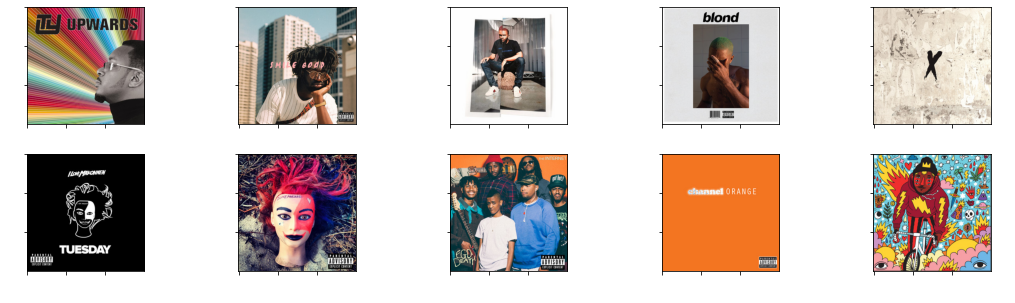

In [34]:
visualize_songs(list_id=recommend.head(10)['id'])